In [1]:
from glob import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fragment_count.utils import *
from fragment_count.views import plot_motif

In [2]:
tumor_samples = glob('fragment_count/output/tumor_derived/*.json')
norm, var = load_samples_as_frame(
    tumor_samples, 
    field_name='fourmer',
)

/home/donkerhc/avenio/fragment_count/utils.py:188: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  items, keys=names, names=["Patient ID", "sample number", item_name], axis=0


In [16]:
motifs = ['CCCA', 'CCAG', 'CCTG', 'TAAA', 'AAAA', 'TTTT']
motifs_compl = [complement(m) for m in motifs]
pool_norm = pool_and_normalise(norm)
pool_var = pool_and_normalise(var)

<ErrorbarContainer object of 3 artists>

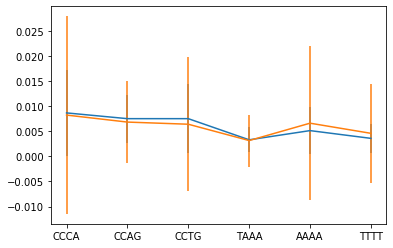

In [5]:
p_pat_norm = pool_norm.groupby('4mer').mean()
dp_pat_norm = pool_norm.groupby('4mer').std()
p_pat_var = pool_var.groupby('4mer').mean()
dp_pat_var = pool_var.groupby('4mer').std()
plt.errorbar(x=motifs, y=p_pat_norm[motifs], yerr=dp_pat_norm[motifs])
plt.errorbar(x=motifs, y=p_pat_var[motifs], yerr=dp_pat_var[motifs])

In [19]:
p_norm = safe_normalise(pool(norm))
p_var = safe_normalise(pool(var))

In [10]:
def entropy(p):
    S = -p * np.log(p)/np.log(256)
    return S.sum()

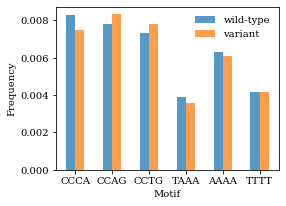

In [42]:
plot_motif(motifs, p_norm.loc[motifs], p_var.loc[motifs])
plt.savefig('figs/fourmer.png', bbox_inches='tight')

In [12]:
S_norm = pool_and_normalise(norm).groupby('Patient ID').apply(entropy)
S_var = pool_and_normalise(var).groupby('Patient ID').apply(entropy)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


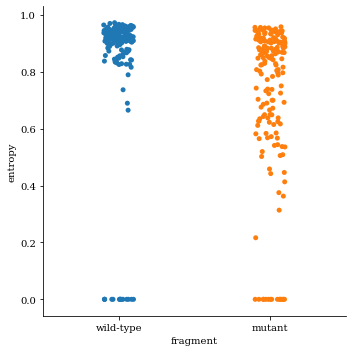

In [13]:
mutant_wildtype = pd.concat(
    [pd.DataFrame({'entropy': S_norm, 'fragment': 'wild-type'}),
    pd.DataFrame({'entropy': S_var, 'fragment': 'mutant'})],
    axis=0,
)
sns.catplot(data=mutant_wildtype, x='fragment', y='entropy')

In [14]:
entropy(p_norm), entropy(p_var)

(0.9742257975542008, 0.9717660323286144)

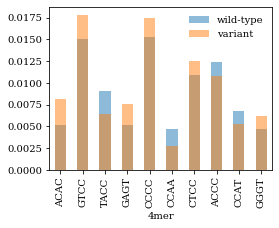

In [15]:
plt.rc('font', family='serif')
fig = plt.figure(figsize=(4, 3))
p_diff = abs(p_norm - p_var).sort_values(ascending=False)
top10_4mer = p_diff[:10].index
p_norm.loc[top10_4mer].plot.bar(color='C0', alpha=0.5, label='wild-type')
p_var.loc[top10_4mer].plot.bar(color='C1', alpha=0.5, label='variant')
plt.legend(frameon=False)
plt.savefig('figs/4mer_top10_difference.png', bbox_inches='tight')